In [1]:

import radkit_lamp as rkl
import mfdf
import trajan as tr
import bag_to_h5_to_measurement
import matplotlib.pyplot as plt
import numpy as np
import os

%load_ext autoreload
%autoreload 2

/home/emil/anaconda3/envs/radkit-dev/lib/python3.9/site-packages/pytools/persistent_dict.py:63: RecommendedHashNotFoundWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "


In [2]:
sys_config, recon_config = mfdf.io.load_configs(*rkl.get_configs("minilamp"))
recon_config.set_param("E", 1332.0)
recon_config.set_param("path_padding", 20)
recon_config.set_param("voxel_size", 4)

In [3]:
bag_name = "2023_07_13_20_08_30"
base_path = "/home/emil/data/RFS/2023_07_13_overshoot_chase_and_x-dips"
bag_name = "2023_09_14_21_39_34"
base_path = "/home/emil/data/RFS/Baltimore"

meas_folder_path = os.path.join(base_path, bag_name)
meas_folder_path = '/home/emil/data/minilamp/2021_10_Dugway/2021_10_06_23_12_37'
meas = bag_to_h5_to_measurement.folder_to_measurement(
    meas_folder_path, recon_config, sys_config
)

Found data.bag.h5 file in /home/emil/data/minilamp/2021_10_Dugway/2021_10_06_23_12_37


In [4]:
import pyopencl as cl
# List all platforms and their devices
for platform in cl.get_platforms():
    print(f"\nPlatform: {platform.name}")
    for device in platform.get_devices():
        print(f"  Device: {device.name}")
        print(f"    Type: {cl.device_type.to_string(device.type)}")
        print(f"    Memory (global): {device.global_mem_size / (1024**3):.2f} GB")
        print(f"    Max compute units: {device.max_compute_units}")


Platform: NVIDIA CUDA
  Device: NVIDIA GeForce RTX 4070 Laptop GPU
    Type: ALL | GPU
    Memory (global): 7.75 GB
    Max compute units: 36

Platform: Portable Computing Language
  Device: pthread-13th Gen Intel(R) Core(TM) i9-13900H
    Type: ALL | CPU
    Memory (global): 60.47 GB
    Max compute units: 20


In [5]:
import pyopencl as cl
device_name = cl.get_platforms()[0].get_devices()[0].name
recon_config.set_param("device", device_name)

In [6]:
bkg_estimate = recon.construct_rad_tensor("gpsl").data

NameError: name 'recon' is not defined

In [23]:
bkg_estimate -= 3
bkg_estimate[bkg_estimate < 0] = 0

In [37]:
bkg_estimate.shape

(7390, 2)

In [108]:
bkg_zeros = np.zeros(bkg_estimate.shape, dtype=np.float32)

In [ ]:
np.full(bkg_estimate.shape, fill_value=np.mean(bkg_estimate), dtype=np.float32)

In [116]:
recon_config.set_param('bkg_estimate', None)

In [7]:
status = mfdf.tools.status.Status(name="mfdf recon", quiet=True)

recon = mfdf.Reconstruction(measurement=meas, config=recon_config, status=status)
image_gpsl1, bkgs_gpsl1 = recon.compute_gpsl()
fp_gpsl1, loss_gpsl1 = recon.compute_forward_projection(image=image_gpsl1, bkgs=bkgs_gpsl1, return_loss=True, return_as_binmode=False)
image_gpsl2, bkgs_gpsl2 = recon.compute_gpsl(bkg_estimate=fp_gpsl1.data)
fp_gpsl2, loss_gpsl2 = recon.compute_forward_projection(image=image_gpsl2, bkgs=bkgs_gpsl1, return_loss=True, return_as_binmode=False)

In [14]:
recon_apsl = recon.to_apsl_recon()
recon_apsl.recon()

zero-source likelihood = 8649.9802
--------------------
Number of sources: 0
Attempting to add another source...
New source accepted (1 total)
Optimizing source positions and weights: Optspace
--------------------
Number of sources: 1
Attempting to add another source...
New source accepted (2 total)
Optimizing source positions and weights: Optspace
Dropping sources based on BIC
  s:  [ 6.19074162e+05 -1.78889510e+02 -1.95922034e+02  1.90941072e+01]
Sources combined: Re-optimizing
Optimizing source positions and weights: Optspace
--------------------
Number of sources: 1
Attempting to add another source...
New source accepted (2 total)
Optimizing source positions and weights: Optspace
--------------------
Number of sources: 2
Attempting to add another source...
New source rejected
--------------------
Attempting to clean up


In [49]:
type(recon_apsl)

psl.apsl.APSL

In [48]:
recon_apsl.srcs[1]

array([ 8.10446921e+07, -2.07613470e+02, -2.38071240e+02,  1.77813981e+01])

Data gross counts: 3351
APSL sum gross counts: 3351.0
Source 1 gross counts: 1787.6
Source 2 gross counts: 632.5
fpll: (2, 7390, 2)
signal: (7390, 2)


<Axes: xlabel='Measurement number', ylabel='Counts'>

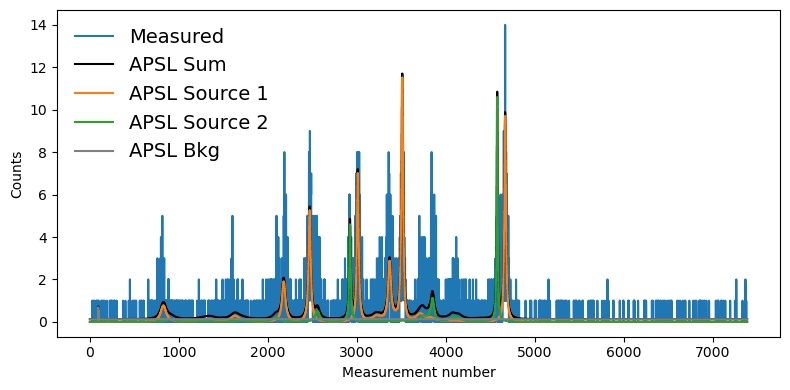

In [28]:
recon_apsl.plot_counts()

In [25]:
apsl_fp = recon_apsl.forward_project()

[[ 2.01092214e+08 -1.76906573e+02 -1.96466865e+02  2.04095431e+01]
 [ 8.10446921e+07 -2.07613470e+02 -2.38071240e+02  1.77813981e+01]]


AttributeError: 'Legend' object has no attribute 'legendHandles'

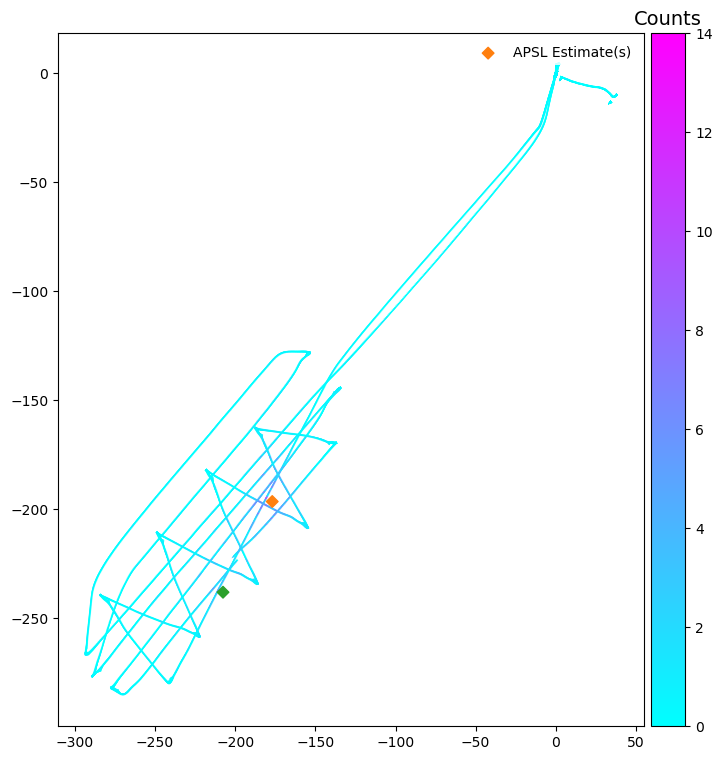

In [17]:
recon_apsl.plot_image_xy(figsize=(9, 9))
# meas.world.copy().downsample(frac=1e-2).plot(plane="xy", colorize_by="k")
plt.gca().set_aspect("equal")

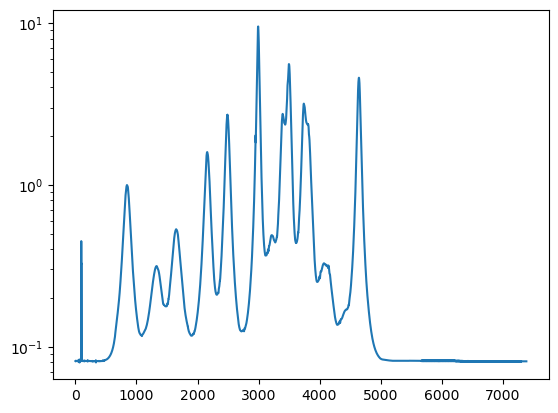

In [104]:
plt.plot(bkgs_gpsl2.data.sum(1))
plt.yscale('log')
# plt.ylim(7e-2, 0.1e0)

In [112]:
image_gpsl1

ReconstructedImage3D (gpsl):
    Header:
        timestamp: None
        frame_id: None
        child_frame_id: None
    VoxelGridMeta:
        x: extent=(-313.7874,  +58.2127), pitch=4.000, num=93
        y: extent=(-304.4765,  +23.5235), pitch=4.000, num=82
        z: extent=(  +3.5710,   +7.5710), pitch=4.000, num=1
    Image3DMeta:
        origin: reconstruction
        fields: ('meas', 'meas_history', 'recon_config', 'recon_mode', 'recon_specs')
    builtin_props:
        x: range=(-311.787, 56.213), mean=-127.787
        y: range=(-302.476, 21.524), mean=-140.476
        z: range=(5.571, 5.571), mean=5.571
        mask: N/A
        ix: range=(0, 92), mean=46.0
        iy: range=(0, 81), mean=40.5
        iz: range=(0, 0), mean=0.0
    user_props:
        bkgs: range=(0.000, 2.309), mean=1.039, fill=0.000
        nll: range=(7414.559, 11281.636), mean=9507.227, fill=11281.636
        sens: range=(0.000, 0.000), mean=0.000, fill=0.000
        var_w: range=(73122537472.000, 43896532

In [105]:
image_gpsl1.metrics

{'best_fit_activity': array([23043.6169407 , 17115.09322622, 29632.04081835]),
 'best_fit_activity_units': 'uCi of Co60',
 'best_fit_activity_interval_sigma': 2,
 'best_fit_idx': 2810}

In [106]:
image_gpsl2.metrics

{'best_fit_activity': array([2491.25791131, 1501.74350878, 3726.40372398]),
 'best_fit_activity_units': 'uCi of Co60',
 'best_fit_activity_interval_sigma': 2,
 'best_fit_idx': 1984}

Data gross counts: 3351
APSL sum gross counts: 3351.0
Source 1 gross counts: 1787.6
Source 2 gross counts: 632.5
fpll: (2, 7390, 2)
signal: (7390, 2)


<Axes: xlabel='Measurement number', ylabel='Counts'>

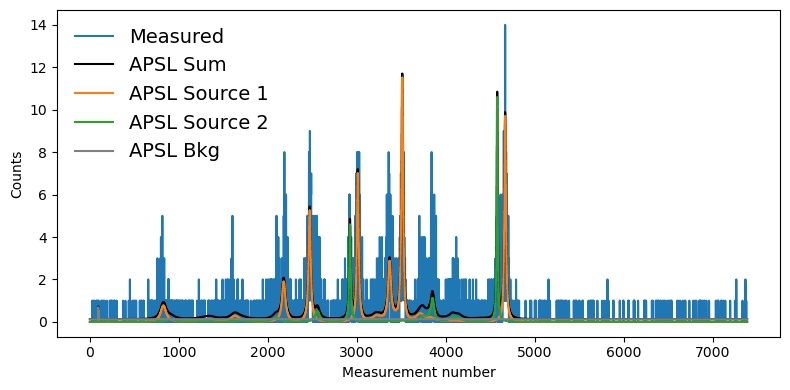

In [31]:
recon_apsl.plot_counts()


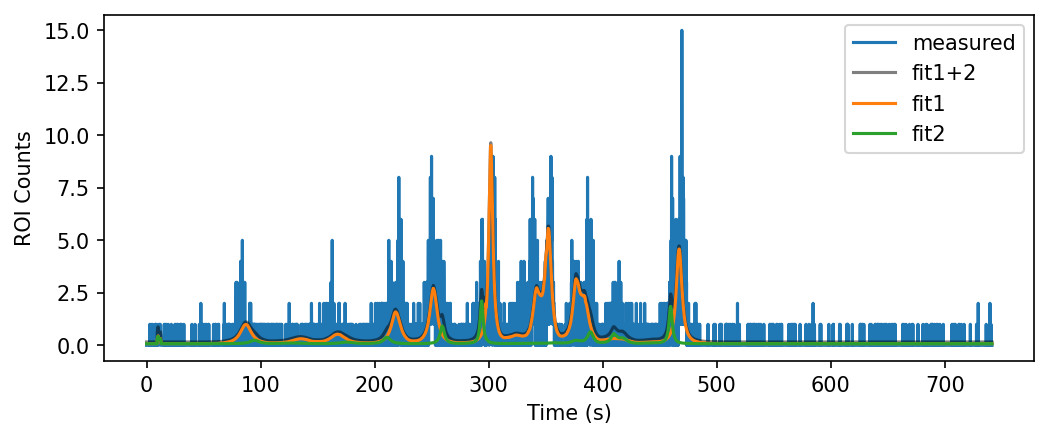

In [37]:
plt.figure(figsize=(8, 3), dpi=150)
plt.plot(
    recon.meas.traj.ts - recon.meas.traj.ts[0],
    recon.construct_rad_tensor("gpsl").data.sum(1),
    label="measured",
)
plt.plot(recon.meas.traj.ts - recon.meas.traj.ts[0], fp_gpsl1.data.sum(1) + fp_gpsl2.data.sum(1), label="fit1+2", alpha=0.5, c='k')
plt.plot(recon.meas.traj.ts - recon.meas.traj.ts[0], fp_gpsl1.data.sum(1), label="fit1")
plt.plot(recon.meas.traj.ts - recon.meas.traj.ts[0], fp_gpsl2.data.sum(1), label="fit2", alpha=1, ls='-')
# plt.plot(recon.meas.traj.ts - recon.meas.traj.ts[0], apsl_fp.sum(1), label="apsl", alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("ROI Counts")
plt.legend()
# plt.yscale('log')
plt.show()

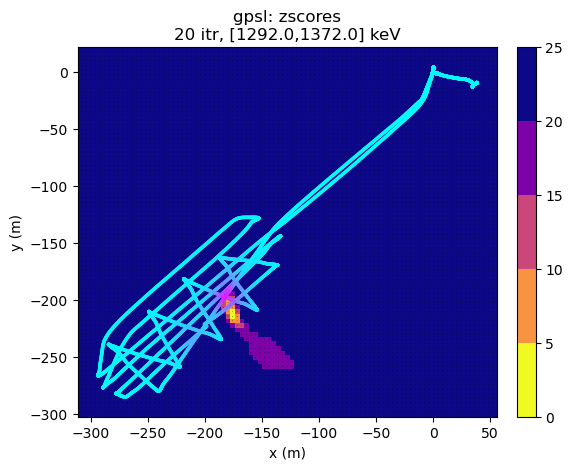

In [59]:
image_gpsl1.plot(prop="zscores", plane="xy", reduction="min")

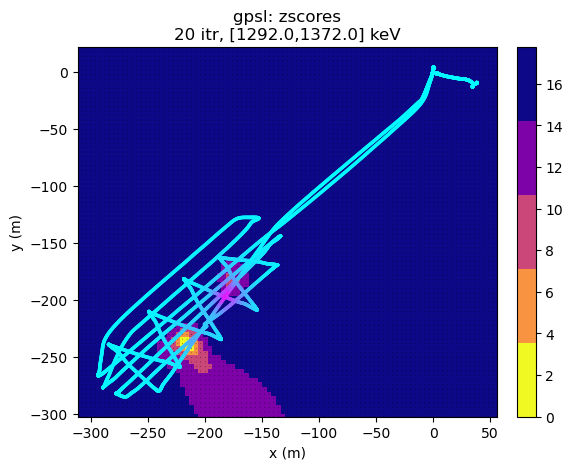

In [61]:
image_gpsl2.plot(prop="zscores", plane="xy", reduction="min")

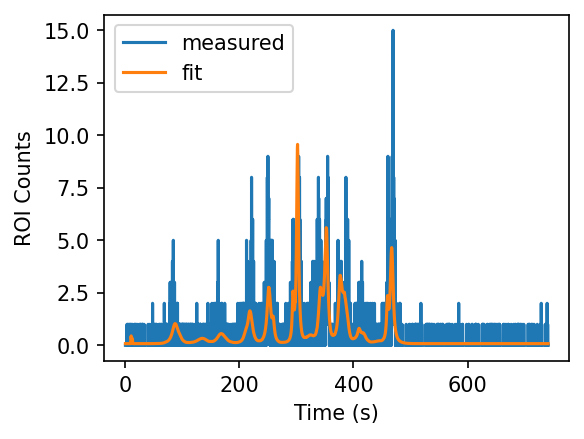

In [43]:
# there is also a compute_forward_projection method defined to forward project an image back into measurement space
fp_gpsl, loss_gpsl = recon.compute_forward_projection(
    image=image_gpsl,  # the image to project
    bkgs=bkgs_gpsl,  # any backgrounds to include in the projection
    return_loss=True,  # whether to compute and return the loss to measured data
    return_as_binmode=False,  # whether the returned projection is a ci.Tensor or ci.Binmode
)
# the forward projection is of shape num poses by num detectors
# print(f"Shape: {fp_gpsl.data.shape}")

# useful to sum and plot over poses to see the fit
# can also overlay it on the measured data
plt.figure(figsize=(4, 3), dpi=150)
plt.plot(
    recon.meas.traj.ts - recon.meas.traj.ts[0],
    recon.construct_rad_tensor("gpsl").data.sum(1),
    label="measured",
)
plt.plot(recon.meas.traj.ts - recon.meas.traj.ts[0], fp_gpsl.data.sum(1), label="fit")
plt.xlabel("Time (s)")
plt.ylabel("ROI Counts")
plt.legend()
plt.show()

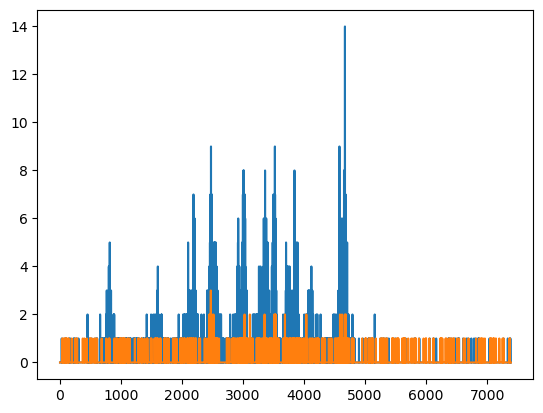

In [44]:
plt.plot(recon.construct_rad_tensor("gpsl").data[:,0])
plt.plot(recon.construct_rad_tensor("gpsl").data[:,1])

In [69]:
recon_config.set_param("mode/occlusion/n_iter", 6)
recon_config.set_param("compute_dose_map", False)
recon_config.set_param("device_mem_max", 2.0)
recon_config.set_param("gross_counts_energy_window", [120, 3000])
recon_config.set_param("mode/occlusion/regularizer_params/mean_sens/enabled", False)
recon_config.set_param("voxel_size", 1.0)

In [70]:
recon_o = mfdf.Reconstruction(measurement=meas, config=recon_config, status=status)
image_occlusion, bkgs_occlusion = recon_o.compute_occlusion()

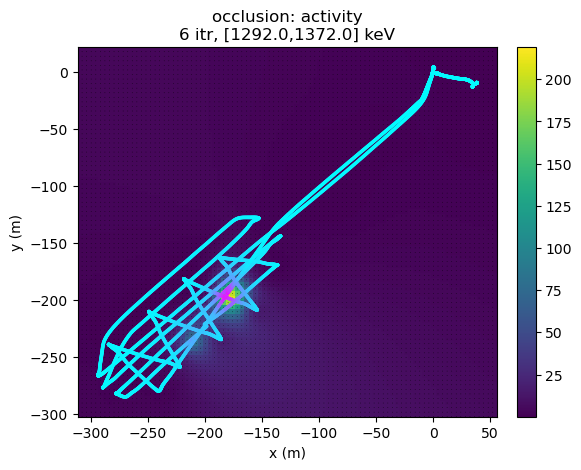

In [74]:
image_occlusion.plot(prop="activity", plane="xy", reduction="max")

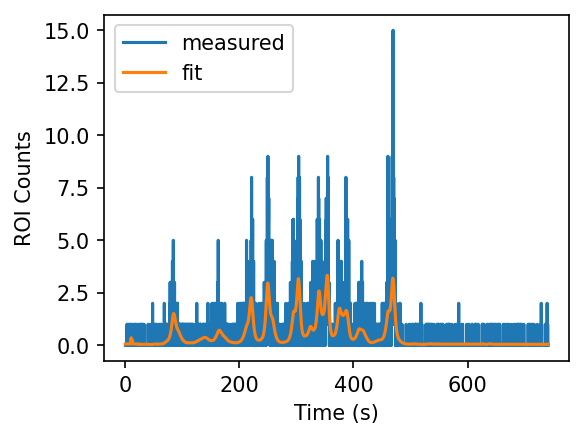

In [71]:
# plot forward projection
fp_occlusion, loss_occlusion = recon_o.compute_forward_projection(image=image_occlusion, bkgs=bkgs_occlusion, return_loss=True, return_as_binmode=False)
plt.figure(figsize=(4, 3), dpi=150)
plt.plot(
    recon.meas.traj.ts - recon.meas.traj.ts[0],
    recon.construct_rad_tensor("gpsl").data.sum(1),
    label="measured",
)
plt.plot(recon.meas.traj.ts - recon.meas.traj.ts[0], fp_occlusion.data.sum(1), label="fit")
plt.xlabel("Time (s)")
plt.ylabel("ROI Counts")
plt.legend()
plt.show()

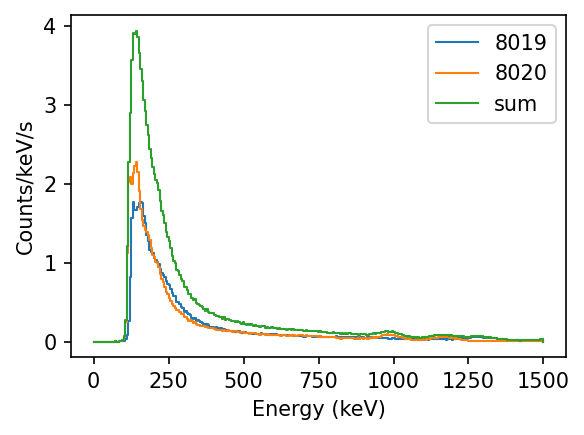

In [11]:
fig = plt.figure(figsize=(4, 3), dpi=150)
meas.plot_spectrum(
    energy_edges=np.linspace(0, 1500, 300),  # how to bin in energy
    sum_dets=False,  # whether to sum up individual detectors
    normalize_by_energy=True,  # divide by energy bin widths
    normalize_by_time=True,  # divide by time to get rate
)
meas.plot_spectrum(
    energy_edges=np.linspace(0, 1500, 300),
    sum_dets=True,
    normalize_by_energy=True,
    normalize_by_time=True,
)
plt.legend()
fig.set_tight_layout(True)

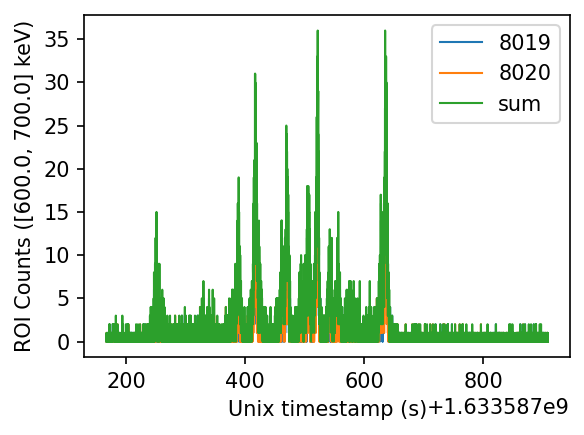

In [12]:
fig = plt.figure(figsize=(4, 3), dpi=150)
meas.plot_counts(
    time_edges=meas.traj.ts_edges,  # how to bin time
    normalize_by_time=False,  # divide by time bin widths
    energy_bounds=[600, 700],  # energy ROI
    sum_dets=False,  # whether to sum up individual detectors
)
meas.plot_counts(
    time_edges=meas.traj.ts_edges,
    normalize_by_time=False,
    energy_bounds=[600, 700],
    sum_dets=True,
)
fig.set_tight_layout(True)
plt.legend()

In [13]:
meas.world.y.shape

(7626,)

In [48]:
# we can easily plot a projection of the image on our measurement
plt.figure(figsize=(8, 4), dpi=150)
image_occlusion.plot(
    prop="weights",  # which property of the voxelgrid to plot
    plane="xy",  # which plane for projection
    plot_pc=False,
    plot_traj=True,
    reduction="max",  # how to reduce on the projection
    mask_outliers=False,  # whether to mask out values outside the vrange
    # vmin=None,  # minimum value of the colorscale
    # vmax=2e6,  # maximum value of the colorscale
    draw_colorbar=True,  # whether to draw the colobar
    colorbar_kwargs=None,  # additional kwargs sent to the colorbar creation call
    # unmask_all=True,  # plot all voxels (unmasked) using fill values or just the occupied (masked)
    cmap="plasma_r",  # colormap
    cmap_discretize=None,  # whether to discretize the cmap and with how many discretizations
    norm=None,  # normalization
    # pc_pts=5e5,  # additional kwargs sent to Measurement.plot()
    # pc_kwargs={"colorize_by": "intensity", "vmax": 100, "cmap": "Greys_r"},
)
# plt.scatter(-180, -200, zorder=11, s=100, c='r')

NameError: name 'image_occlusion' is not defined

<Figure size 1200x600 with 0 Axes>

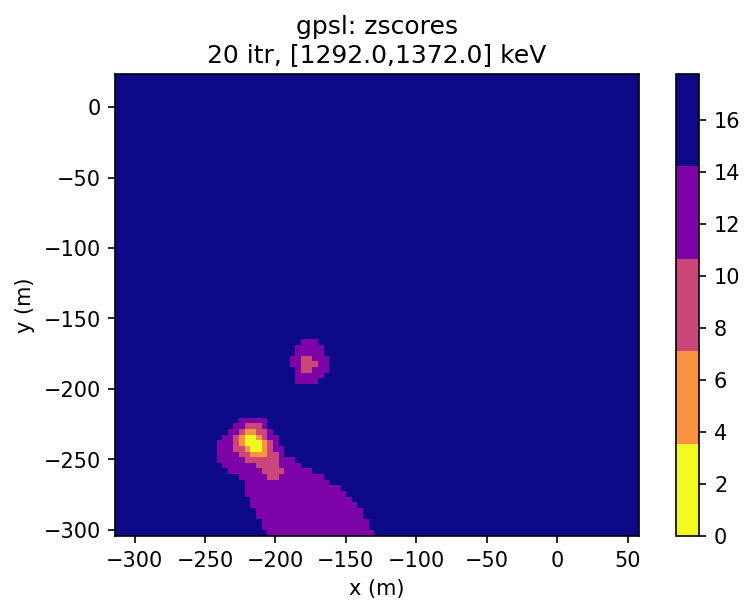

In [47]:
# we can easily plot a projection of the image on our measurement
plt.figure(figsize=(8, 4), dpi=150)
image_gpsl.plot(
    prop="zscores",  # which property of the voxelgrid to plot
    plane="xy",  # which plane for projection
    plot_pc=False,
    plot_traj=False,
    reduction="min",  # how to reduce on the projection
    mask_outliers=False,  # whether to mask out values outside the vrange
    vmin=None,  # minimum value of the colorscale
    # vmax=15,  # maximum value of the colorscale
    draw_colorbar=True,  # whether to draw the colobar
    colorbar_kwargs=None,  # additional kwargs sent to the colorbar creation call
    unmask_all=True,  # plot all voxels (unmasked) using fill values or just the occupied (masked)
    cmap="plasma_r",  # colormap
    cmap_discretize=5,  # whether to discretize the cmap and with how many discretizations
    norm=None,  # normalization
    # pc_pts=5e5,  # additional kwargs sent to Measurement.plot()
    # pc_kwargs={"colorize_by": "intensity", "vmax": 100, "cmap": "Greys_r", 'size': 0.1},
)

In [23]:
def plot_gpsl(
    image_gpsl,
    meas,
    alt=None,
    true_location=None,
    xmin=None,
    xmax=None,
    ymin=None,
    ymax=None,
    title=None,
    source_found=True,
    padding=20,
    full_measurement=None,
):
    fig, ax = plt.subplots(
        1, 2, figsize=(6.9, 2.6), dpi=150, gridspec_kw={"width_ratios": [1, 20]}
    )
    if xmin is None:
        meas_limits = full_measurement if full_measurement is not None else meas
        xmin, ymin, zmin = meas_limits.traj.get_min_xyz()
        xmax, ymax, zmax = meas_limits.traj.get_max_xyz()
        xmin = xmin - padding
        xmax = xmax + padding
        ymin = ymin - padding
        ymax = ymax + padding
    vmin, vmax = None, None
    image_gpsl.plot(
        prop="zscores",  # which property of the voxelgrid to plot
        plane="xy",  # which plane for projection
        reduction="min",  # how to reduce on the projection
        mask_outliers=True,  # whether to mask out values outside the vrange
        vmin=0,  # minimum value of the colorscale
        vmax=5,  # maximum value of the colorscale
        draw_colorbar=True,  # whether to draw the colobar
        colorbar_kwargs={
            "pad": 0.13,
            "label": "z-scores",
        },  # additional kwargs sent to the colorbar creation call
        unmask_all=True,  # plot all voxels (unmasked) using fill values or just the occupied (masked)
        cmap="plasma_r",  # colormap
        cmap_discretize=5,  # whether to discretize the cmap and with how many discretizations
        norm=None,
        plot_pc=False,
        xmin=xmin,
        ymin=ymin,
        zmin=None,
        xmax=xmax,
        ymax=ymax,
        zmax=None,
        # traj_kwargs={'draw_colorbar':True, 'vmin':0, 'vmax':vmax}
    )

    meas.plot(
        plot_pc=False,
        xmin=xmin,
        xmax=xmax,
        ymin=ymin,
        ymax=ymax,
        traj_kwargs={"draw_colorbar": True, "vmin": vmin, "vmax": vmax},
    )
    # coordinates = np.array([[0,0], [-50,0], [-50,-30], [-20,-30], [-20,0]])
    # plt.plot(coordinates.T[0,:],coordinates.T[1,:], color='k', ls='--', label='Planned \n path')

    # mark the best estimated voxel for the source
    if source_found:
        idx = np.argmin(image_gpsl["zscores"])
        plt.scatter(
            image_gpsl["x"][idx],
            image_gpsl["y"][idx],
            marker="*",
            color="r",
            alpha=0.8,
            label="Predicted\n source\n location",
            zorder=10,
        )

    # Plot the true position if given
    if true_location is not None:
        plt.scatter(
            *true_location,
            marker="x",
            color="pink",
            alpha=1,
            label="True\n source\n location",
            zorder=9,
            s=120,
        )
    plt.title("")
    plt.title(title)

    #     plt.legend(loc=4, prop={"size": 10})
    # plot the altitude separately
    ax[0].set_xlim([-0.1, 0.1])
    ax[0].set_ylim([-1, 30])
    ax[0].set_ylabel("Altitude (m)")
    if alt is not None:
        ax[0].scatter(0, alt, marker="x", color="r", zorder=10, s=250)
    ax[0].get_xaxis().set_visible(False)

    fig.set_tight_layout(True)
    return fig, ax

In [24]:
time_takeoff = meas.traj.ts[np.where(meas.traj.pz > 4)[0][0]]
time_land = meas.traj.ts[np.where(meas.traj.pz > 4)[0][-1]]
air_time = time_land - time_takeoff
time_padding = 10
meas_air = meas.copy()
meas_air.cut_time(t=(time_takeoff - time_padding, time_land + time_padding))

RadData (Listmode):
   Scalars:
      fields:    
         __e: value=0, dtype=int8
   Arrays:
      length: 488881
      fields:    
         det_id: range=(8019, 8020), dtype=uint32
         timestamp_det: range=(1633587164.1925104, 1633587713.4899077), dtype=float64
         energy: range=(70.64468383789062, 4926.6015625), dtype=float32
         x: range=(0.0, 0.0), dtype=float32
         y: range=(0.0, 0.0), dtype=float32
         z: range=(0.0, 0.0), dtype=float32
         num_interaction: range=(1, 1), dtype=uint8
         channel: range=(9, 4095), dtype=int16
         timestamp_sys: range=(1633587164.192509, 1633587713.489906), dtype=float64
Trajectory:
    Header:
        timestamp: None [DISABLED]
        frame_id: map
        child_frame_id: det
    num nodes: 5441
    x: range=(-293.961, 0.944)
    y: range=(-285.117, 3.886)
    z: range=(0.120, 15.268)
    time: ts_range=(1633587166.904, 1633587713.400), duration=546.496 sec
    ts_edges: undefined
VoxelGrid:
    Header:
  

In [26]:
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse


def pad_image(x, y, z):
    x_unique = np.unique(x)
    y_unique = np.unique(y)

    x_step = x_unique[1] - x_unique[0]
    y_step = y_unique[1] - y_unique[0]

    padding_x = int(0.2 * len(x_unique))
    padding_y = int(0.2 * len(y_unique))

    # Create padded x and y arrays
    x_pad = np.linspace(
        min(x_unique) - padding_x * x_step,
        max(x_unique) + padding_x * x_step,
        len(x_unique) + 2 * padding_x,
    )
    y_pad = np.linspace(
        min(y_unique) - padding_y * y_step,
        max(y_unique) + padding_y * y_step,
        len(y_unique) + 2 * padding_y,
    )

    # Create 2D array from z and find positions for x, y in x_unique and y_unique
    z_2d = np.zeros((len(y_unique), len(x_unique)))
    for xi, yi, zi in zip(x, y, z):
        ix = np.where(x_unique == xi)[0][0]
        iy = np.where(y_unique == yi)[0][0]
        z_2d[iy, ix] = zi

    # Add padding to z_2d with linear ramp to zero at the edges
    z_2d_pad = np.pad(
        z_2d, ((padding_y, padding_y), (padding_x, padding_x)), "linear_ramp"
    )

    x_pad, y_pad = np.meshgrid(x_pad, y_pad)
    x_pad = x_pad.flatten()
    y_pad = y_pad.flatten()
    z_pad = z_2d_pad.flatten()
    return x_pad, y_pad, z_pad


def gaussian_2d(coords, amp, x0, y0, sigma_x, sigma_y):
    x, y = coords
    return amp * np.exp(
        -((x - x0) ** 2 / (2 * sigma_x**2) + (y - y0) ** 2 / (2 * sigma_y**2))
    )


def fit_zscore_widths(image):
    """Returns the widths of a fitted 2D Gaussian in x and y"""
    if not "best_fit_activity" in image.metrics:
        return -1, 0, 0, 100, 100
    x, y, z = image["x"], image["y"], image["zscores"]
    # invert the scores so higher is better. zscore 0 is 5 points, zscore >= 5 is 0 points
    z = 5 - z
    z[z < 0] = 0
    x, y, z = pad_image(x, y, z)
    initial_guess = [max(z), np.mean(x), np.mean(y), np.std(x), np.std(y)]
    params, _ = curve_fit(gaussian_2d, (x, y), z, p0=initial_guess)
    amp, x0, y0, sigma_x, sigma_y = params
    return amp, x0, y0, abs(sigma_x), abs(sigma_y)

In [ ]:
times = np.arange(0, air_time + 1, 2)
images = []
timess = []
for i, t in enumerate(times):
    meas_time = meas_air.copy()
    meas_time.cut_time(t=(None, meas_time.traj.ts[0] + t))
    world = bag_to_h5_to_measurement.create_world(meas_time.traj, recon_config)
    recon = mfdf.Reconstruction(
        measurement=meas_time, config=recon_config, status=status
    )
    try:
        image_gpsl, bkgs_gpsl = recon.compute_gpsl()
    except:
        continue
    images.append(image_gpsl)
    timess.append(t)
    fig, ax = plot_gpsl(
        image_gpsl, meas_time, full_measurement=meas, alt=meas_time.traj.pz[-1]
    )
    if "best_fit_activity" in image_gpsl.metrics:
        amp, x0, y0, sigma_x, sigma_y = fit_zscore_widths(image_gpsl)
        ellipse = Ellipse(
            (x0, y0), 2 * sigma_x, 2 * sigma_y, edgecolor="r", facecolor="none"
        )
        ax[1].add_patch(ellipse)
    plt.savefig(f"./plots/airtime_{i:03d}.png", dpi=150)
    plt.close(fig)

/home/emil/anaconda3/envs/radkit-stable/lib/python3.9/site-packages/pyopencl/array.py:178: RuntimeWarning: divide by zero encountered in divide
  result = (x1/x2).dtype
/home/emil/anaconda3/envs/radkit-stable/lib/python3.9/site-packages/mfdf/algorithms/gpsl.py:550: UserWarning: gpsl_bm() computed nan in var_w_np
  warnings.warn("gpsl_bm() computed nan in var_w_np")


In [262]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

xmax, ymax, zmax = meas.traj.get_max_xyz()
xmin, ymin, zmin = meas.traj.get_min_xyz()
padding = 20
for i, image in enumerate(images[:]):
    x, y, z = image["x"], image["y"], image["zscores"]
    z = 25 - z
    z = z - 20
    z[z < 0] = 0

    # 2D Gaussian function to fit
    def gaussian_2d(coords, amp, x0, y0, sigma_x, sigma_y):
        x, y = coords
        return amp * np.exp(
            -((x - x0) ** 2 / (2 * sigma_x**2) + (y - y0) ** 2 / (2 * sigma_y**2))
        )

    coords = np.vstack([x, y])
    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    sc = ax.scatter(x, y, c=z, cmap="viridis", vmax=5, vmin=0)
    cb = plt.colorbar(sc, ax=ax)
    cb.set_label("Zmax - Z")

    if "best_fit_activity" in image.metrics:
        x, y, z = pad_image(x, y, z)
        # Curve fitting
        initial_guess = [max(z), np.mean(x), np.mean(y), np.std(x), np.std(y)]
        params, _ = curve_fit(gaussian_2d, (x, y), z, p0=initial_guess)
        amp, x0, y0, sigma_x, sigma_y = params
        # params, _ = curve_fit(gaussian_2d, (x, y), z)
        # amp, x0, y0, sigma_x, sigma_y = params

        # R-squared calculation
        z_pred = gaussian_2d((x, y), *params)
        r_squared = 1 - np.sum((z - z_pred) ** 2) / np.sum((z - np.mean(z)) ** 2)
        ellipse = Ellipse(
            (x0, y0), 2 * sigma_x, 2 * sigma_y, edgecolor="r", facecolor="none"
        )
        ax.add_patch(ellipse)
        # print(f"Amplitude: {round(amp)}, Center: ({x0}, {y0}), Widths: (σ_x: {sigma_x}, σ_y: {sigma_y}), R-squared: {r_squared}")
        ax.set_title(f"Widths: (σ_x: {abs(sigma_x):.2f}, σ_y: {abs(sigma_y):.2f})")
    ax.axis("equal")
    ax.set_xlim([xmin - padding, xmax + padding])
    ax.set_ylim([ymin - padding, ymax + padding])
    fig.savefig(f"./plots/sigma_{i:03d}_fit.png", dpi=150)
    plt.close(fig)

/home/emil/anaconda3/envs/radkit-dev/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_11986/1577616393.py:39: RuntimeWarning: invalid value encountered in scalar divide
  r_squared = 1 - np.sum((z - z_pred)**2) / np.sum((z - np.mean(z))**2)


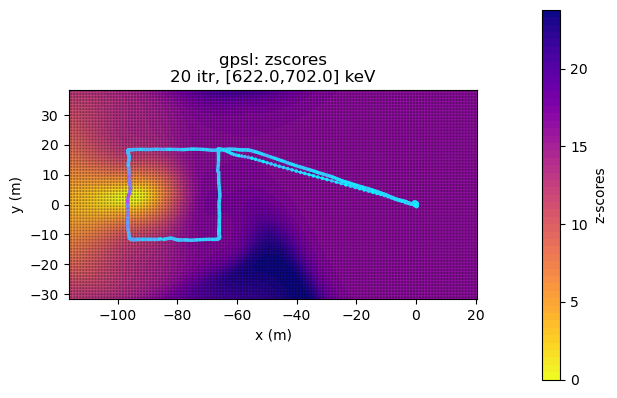

In [250]:
images[-1].plot(
    prop="zscores",  # which property of the voxelgrid to plot
    plane="xy",  # which plane for projection
    reduction="min",  # how to reduce on the projection
    mask_outliers=True,  # whether to mask out values outside the vrange
    vmin=None,  # minimum value of the colorscale
    vmax=None,  # maximum value of the colorscale
    draw_colorbar=True,  # whether to draw the colobar
    colorbar_kwargs={
        "pad": 0.13,
        "label": "z-scores",
    },  # additional kwargs sent to the colorbar creation call
    unmask_all=True,  # plot all voxels (unmasked) using fill values or just the occupied (masked)
    cmap="plasma_r",  # colormap
    cmap_discretize=50,
)

In [251]:
images[3].weights

array([9.69174720e+08, 9.64315584e+08, 9.59532736e+08, ...,
       9.97648560e+07, 1.01915744e+08, 1.04103496e+08], dtype=float32)

Text(0, 0.5, 'Activity (Bq)')

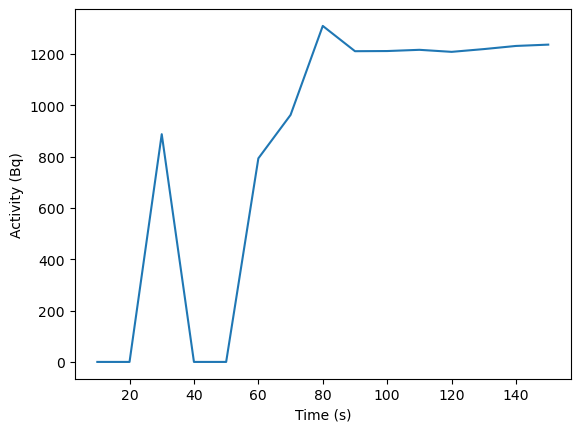

In [252]:
acts = [
    i.metrics["best_fit_activity"][0] if "best_fit_activity" in i.metrics else 0
    for i in images
]
plt.plot(timess, acts)
plt.xlabel("Time (s)")
plt.ylabel("Activity (Bq)")